In [1]:
import ast
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#getdata
dataset=load_dataset('lukebarousse/data_jobs')
df=dataset['train'].to_pandas()
#cleandata
df['job_posted_date']=pd.to_datetime(df['job_posted_date'])
df['job_skills']=df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

d:\python\libs\miniconda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#get only data engineering jobs in US
df_DE_US=df[(df['job_title_short']=="Data Engineer") & (df['job_country']=='United States') ].copy()

#drop nan values from 'salary_year_avg' col.
df_DE_US = df_DE_US.dropna(subset=['salary_year_avg'])

In [3]:
#count the number of rows in the filtered data frame so we could use later for formulas 
DE_job_count = len(df_DE_US)


In [4]:
#explode out the job skills (now there is more rows and I previously made the mistake of counting the rows of the exploded dataframe and got incorrect values)
df_DE_US=df_DE_US.explode('job_skills')

#with aggregate count the median salary and the count for each job skill for data engineers and sort them values
df_DE_US[['salary_year_avg','job_skills']]

df_DE_US_grouped=df_DE_US.groupby('job_skills')['salary_year_avg'].agg(['count','median']).sort_values(by='count', ascending=False)

#formula for counting the skill percent that appears in Data Engineer job postings, the skill percent is adjusted so the scatterplot doesnt look too crowded, the optimal number that I chose was 10
df_DE_US_grouped['skill_percent'] = df_DE_US_grouped['count'] / DE_job_count*100

skill_percent = 10

DE_highdemand_skills = df_DE_US_grouped[df_DE_US_grouped['skill_percent']>skill_percent]


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


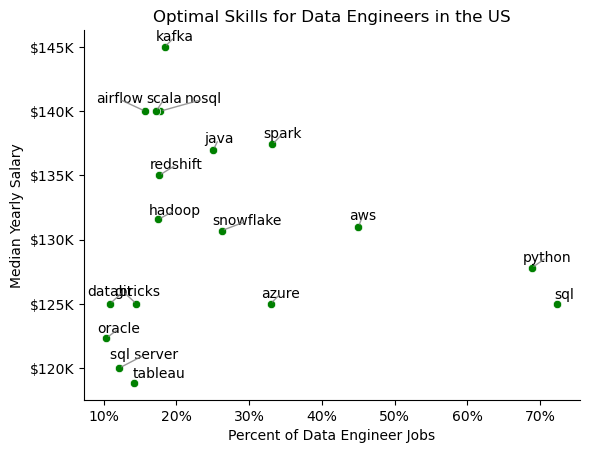

In [5]:
from adjustText import adjust_text

#making the scatterplot w/ seaborn
sns.scatterplot(data=DE_highdemand_skills, x='skill_percent', y='median', color='green')

texts=[]
for i, txt in enumerate(DE_highdemand_skills.index):
    texts.append(plt.text(DE_highdemand_skills['skill_percent'].iloc[i], DE_highdemand_skills['median'].iloc[i],txt,ha='center', va='bottom'))

#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
adjust_text(texts,
            expand_points=(1.5, 1.5),  # Increase this (e.g., from 1.0 to 1.5)
            expand_text=(1.2, 1.2),    # Increase this (e.g., from 1.0 to 1.2)
            arrowprops=dict(arrowstyle='-', color='gray', lw=1, alpha=0.8))

#formatting
sns.despine()
plt.xlabel('Percent of Data Engineer Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Optimal Skills for Data Engineers in the US')


#even more formatting
from matplotlib.ticker import PercentFormatter
ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.tight_layout
plt.show()